## Importing all the Libraries

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import Likelihood, QuantileRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib

from datetime import timedelta
#warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing Data

In [49]:
import pandas as pd

data = pd.read_csv("/home/vnk3019/Gaussian_Reduced_Data.csv")
df = data
df = df.dropna()


## Loading Data

In [50]:
def estimate_cold_pressure(Pmeas,Tmeas,Tcold):
    Patm = 1.01325 #bar
    
    Pcold = (Pmeas + Patm)*(Tcold+273.15)/(Tmeas + 273.15) - Patm
    
    return Pcold

def gazao_rate_model(temperature,pressure,E = 6000, tau0 = 1/3, tire_sw = 275, tire_sh = 80, tire_rim = 22.5):
    R = 8.314e-2 #L*bar/(K*mol) ideal gas constant
    T0 = 293.15 #tempoerature in kelvin
    
    #estimating the approximate volume available in the tire
    Vtire = tire_sw*(((2*tire_sw*tire_sh/100 + tire_rim*25.4)**2)*np.pi/4 - ((tire_rim*25.4)**2)*np.pi/4)*1e-6 #liters
    
    T_K = temperature + 273.15
    gazao_rate = (1/tau0)*np.exp(-E/T_K)*24*3600*pressure # in bar per day lost by diffusion
    
    # estimating the loss of mol of gas per day 
    n_est = gazao_rate*Vtire/R/T0
    
    return n_est

def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load

def calc_nrg_from_classifier(clf,df,val_name):
    fts = ['avg_veh_speed_kph', 'wp_load_kg', 'P_avg_bar']
    df[val_name] = clf.predict(df[fts].values)    
    return df

In [51]:
example_df = pd.read_csv('Example_TimeSeries_Data_KR8833.bz2')

In [52]:
input_list = [x for x in list(example_df) if 'shear' not in x and 'nci' not in x and 'Insp_Damage' not in x]
output_list = [x for x in list(example_df) if x not in input_list]

In [53]:
# drum conditions 
Pinf_bar = 4.1
Load_kg = 1500
Speed_kph = 50
Start_Date = '2022-06-14'

tire_sn = 'AADB-0434'
study_type = 'DrumTesting_Condition5'

tire_type  = 'XLEZ 275/80R22.5'
#Time
freq_samp_hrs = 1 #sample per hour
rg_dates = pd.date_range(pd.to_datetime(Start_Date), pd.to_datetime(Start_Date) + timedelta(int(1e6/Speed_kph/24)),freq = str(freq_samp_hrs) + 'H')
test_df = pd.DataFrame(index = rg_dates)

In [54]:
# non-simulated data (although at this point temperature is estimated)

#age_days
test_df['age_days'] = (test_df.index - test_df.index[0])/timedelta(1)
#avg_speed_kph
test_df['avg_veh_speed_kph'] = Speed_kph
#casing_mileage_kms
test_df['delta_casing_mileage_kms'] = test_df.avg_veh_speed_kph*freq_samp_hrs
test_df['casing_mileage_kms'] = test_df.delta_casing_mileage_kms.cumsum()
#life_num
test_df['Life_Num'] = 1
#POS
test_df['POS'] = '1L'
#wp_load_kg
test_df['wp_load_kg'] = Load_kg
#P_avg_bar
test_df['P_avg_bar'] = Pinf_bar
#T_avg_degC
test_df['T_avg_degC'] = 50

In [55]:
#gazao modeling
test_df['n_rxns_per_hr'] = gazao_rate_model(test_df.T_avg_degC,test_df.P_avg_bar)/24
test_df['n_rxns_cumul'] = test_df.n_rxns_per_hr.cumsum()

#fill in the FEA metrics
rolling_radius = 498.2 #mm, simulation average among all conditions with little variation (taken from XLEZ)
Nrev_per_km = 1/(np.pi*2*rolling_radius*1e-6)
daNmm_to_kilajoule = 1e-5
clf_list = [x for x in os.listdir('./') if 'XLEZ' in x and 'NC_sidewall' in x]
clfs = [joblib.load('./' + x) for x in clf_list]
clf_name = ['_'.join(x.split('_')[1:5]) for x in clf_list]

for clf,clname in zip(clfs,clf_name):
    test_df = calc_nrg_from_classifier(clf,test_df,clname)
    if clname == 'NC_sidewall_SEelm_sumrev':
        #do a summamtion across the number of revolutions and the energy calculated, then convert the energy estimated to kilajoules
        test_df[clname] = (test_df[clname]*Nrev_per_km*test_df['avg_veh_speed_kph']*daNmm_to_kilajoule).cumsum()
test_df['Time'] = test_df.index
test_df.reset_index(drop = True, inplace = True)

In [56]:
def repartition_static_load(total_load, WP = '1L',mount_type = 'dual'):
    #static load based on measurements at LPG for wheel force transducers
    #hard coded values based on fit parameters
    
    if WP[0] == '1':
        tire_pos_type = 'steer'
    elif WP[0] == '2' or WP[0]=='3':
        tire_pos_type = 'drive'
    elif WP[0] == '4' or WP[0]=='5':
        tire_pos_type = 'trailer'
    
    if tire_pos_type == 'steer':
        mount_type = 'single'
        wp_load =total_load*1445.5*total_load**-0.936
    elif tire_pos_type == 'drive':
        wp_load = total_load*0.041*total_load**0.0271
        if mount_type == 'xone':
            wp_load = 2*wp_load
    elif tire_pos_type == 'trailer':
        wp_load = total_load*(0.0343*np.log(total_load) - 0.3073)
        if mount_type == 'xone':
            wp_load = 2*wp_load
    return wp_load


In [57]:
test_df

,age_days,avg_veh_speed_kph,delta_casing_mileage_kms,casing_mileage_kms,Life_Num,POS,wp_load_kg,P_avg_bar,T_avg_degC,n_rxns_per_hr,n_rxns_cumul,NC_sidewall_CVMD_AMP,NC_sidewall_SEelm_sumrev,NC_sidewall_maxCVMD_rev,Time
0,0.000000,50,50,50,1,1L,1500,4.1,50,0.002361,0.002361,0.002538,0.057234,-0.010109,2022-06-14 00:00:00
1,0.041667,50,50,100,1,1L,1500,4.1,50,0.002361,0.004721,0.002538,0.114469,-0.010109,2022-06-14 01:00:00
2,0.083333,50,50,150,1,1L,1500,4.1,50,0.002361,0.007082,0.002538,0.171703,-0.010109,2022-06-14 02:00:00
3,0.125000,50,50,200,1,1L,1500,4.1,50,0.002361,0.009442,0.002538,0.228937,-0.010109,2022-06-14 03:00:00
4,0.166667,50,50,250,1,1L,1500,4.1,50,0.002361,0.011803,0.002538,0.286171,-0.010109,2022-06-14 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19988,832.833333,50,50,999450,1,1L,1500,4.1,50,0.002361,47.185645,0.002538,1144.056091,-0.010109,2024-09-23 20:00:00
19989,832.875000,50,50,999500,1,1L,1500,4.1,50,0.002361,47.188006,0.002538,1144.113326,-0.010109,2024-09-23 21:00:00
19990,832.916667,50,50,999550,1,1L,1500,4.1,50,0.002361,47.190366,0.002538,1144.170560,-0.010109,2024-09-23 22:00:00
19991,832.958333,50,50,999600,1,1L,1500,4.1,50,0.002361,47.192727,0.002538,1144.227794,-0.010109,2024-09-23 23:00:00


In [58]:
test_df.columns

Index(['age_days', 'avg_veh_speed_kph', 'delta_casing_mileage_kms',
       'casing_mileage_kms', 'Life_Num', 'POS', 'wp_load_kg', 'P_avg_bar',
       'T_avg_degC', 'n_rxns_per_hr', 'n_rxns_cumul', 'NC_sidewall_CVMD_AMP',
       'NC_sidewall_SEelm_sumrev', 'NC_sidewall_maxCVMD_rev', 'Time'],
      dtype='object')

In [59]:
tire_data = test_df[['age_days', 'avg_veh_speed_kph', 
       'casing_mileage_kms', 'Life_Num', 'wp_load_kg', 'P_avg_bar',
       'T_avg_degC', 'n_rxns_cumul', 
       'NC_sidewall_CVMD_AMP', 'NC_sidewall_SEelm_sumrev',
       'NC_sidewall_maxCVMD_rev']]

In [38]:
repartition_static_load(3000, WP = '2L',mount_type = 'xone')

305.6082634511665

In [42]:
# Apply the function to change the load
test_df['wp_load_kg'] = test_df.apply(lambda x: repartition_static_load(x['wp_load_kg'], WP='1L', mount_type='xone'), axis=1)

# Perform rolling time series analysis
# This example will show how to calculate the rolling mean for 'wp_load_kg' with a window of 3 periods
#rolling_means = test_df['wp_load_kg'].rolling(window=3).mean()
test_df


,age_days,avg_veh_speed_kph,delta_casing_mileage_kms,casing_mileage_kms,Life_Num,POS,wp_load_kg,P_avg_bar,T_avg_degC,n_rxns_per_hr,n_rxns_cumul,Time,NC_sidewall_CVMD_AMP,NC_sidewall_SEelm_sumrev,NC_sidewall_maxCVMD_rev
0,0.000000,50,50,50,1,1L,1712.137885,4.1,50,0.002361,0.002361,0,0.002538,0.057234,-0.010109
1,0.041667,50,50,100,1,1L,1712.137885,4.1,50,0.002361,0.004721,1,0.002538,0.114469,-0.010109
2,0.083333,50,50,150,1,1L,1712.137885,4.1,50,0.002361,0.007082,2,0.002538,0.171703,-0.010109
3,0.125000,50,50,200,1,1L,1712.137885,4.1,50,0.002361,0.009442,3,0.002538,0.228937,-0.010109
4,0.166667,50,50,250,1,1L,1712.137885,4.1,50,0.002361,0.011803,4,0.002538,0.286171,-0.010109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19988,832.833333,50,50,999450,1,1L,1712.137885,4.1,50,0.002361,47.185645,19988,0.002538,1144.056091,-0.010109
19989,832.875000,50,50,999500,1,1L,1712.137885,4.1,50,0.002361,47.188006,19989,0.002538,1144.113326,-0.010109
19990,832.916667,50,50,999550,1,1L,1712.137885,4.1,50,0.002361,47.190366,19990,0.002538,1144.170560,-0.010109
19991,832.958333,50,50,999600,1,1L,1712.137885,4.1,50,0.002361,47.192727,19991,0.002538,1144.227794,-0.010109


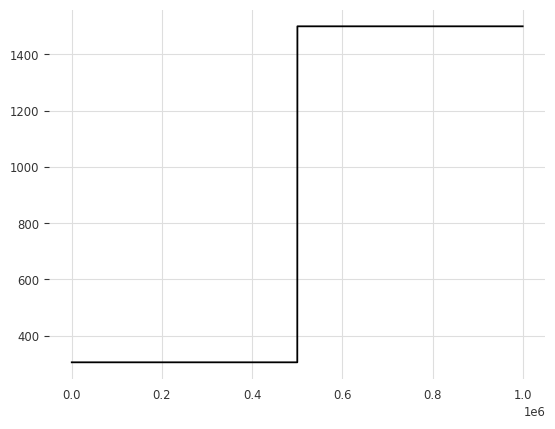

In [73]:


# Updating the load based on the provided function
test_df = repartition_static_load(3000, WP='2L', mount_type='xone')

# Function to change tire location based on mileage and location
def change_tire_location(df, start_mileage, end_mileage, current_location, new_location):
    # Selecting the rows where tire needs to be changed based on the mileage
    df_to_change = df[(df['casing_mileage_kms'] >= start_mileage) & (df['casing_mileage_kms'] <= end_mileage)]
    
    # Change the tire location for selected rows
    df.loc[df_to_change.index, 'wp_load_kg'] = repartition_static_load(3000, WP = new_location,mount_type = 'xone')
    
    return df

# Assuming we have to change tire location from '1L' to '2L' between 200 and 250 kms
tire_data_changed = change_tire_location(tire_data, start_mileage=0, end_mileage=500000, current_location='1L', new_location='2L')


plt.plot(tire_data_changed['casing_mileage_kms'], tire_data_changed['wp_load_kg'])